In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../src/')

from models.XPLORE import XPLORE, posteriors2coordinates
from utils.metrics import NearestCandidates
import utils.visualization as vis

# Questions

In [8]:
dataset = pd.read_excel('~/Data/Smartvote/election23/23_ch_nr-questions_de-fr-it-en.xlsx')
categories = pd.read_excel('~/Data/Smartvote/election23/23_ch_nr-question categories.xlsx', index_col=0)
questions = dataset.filter(['ID_question','question_DE','question_EN','rapide', 'category']).set_index('ID_question')
questions.category = questions.category.map(categories.text_EN.to_dict())
questions

,question_DE,question_EN,rapide,category
ID_question,,,,
32214,Befürworten Sie eine Erhöhung des Rentenalters...,Do you support an increase in the retirement a...,1,Welfare state & family
32215,Soll der Staat mehr Mittel für die Krankenkass...,Should the federal government allocate more fu...,1,Welfare state & family
32216,Bei Ehepaaren ist die Höhe der Rente heute auf...,"For married couples, the pension is currently ...",0,Welfare state & family
32217,Im Rahmen der BVG-Reform sollen die Renten gek...,As part of the reform of the BVG (occupational...,0,Welfare state & family
32218,Soll die bezahlte Elternzeit von heute 14 Woch...,Should paid parental leave be increased beyond...,0,Welfare state & family
...,...,...,...,...
32284,"Soll der Bund im Bereich ""Öffentlicher Verkehr...",Should the federal government spend more or le...,0,Federal budget
32285,"Soll der Bund im Bereich ""Strassenverkehr (mot...",Should the federal government spend more or le...,0,Federal budget
32286,"Soll der Bund im Bereich ""Öffentliche Sicherhe...",Should the federal government spend more or le...,0,Federal budget


In [9]:
questions = questions.replace(r' \[BePart question\]', '', regex=True)
questions = questions.replace(r' \[BePart-Frage\]', '', regex=True)
questions = questions.replace(r' or less', '', regex=True)
questions = questions.replace(r' oder weniger', '', regex=True)

In [10]:
questions.to_csv('../data/questions.csv')

# Candidates

In [2]:
dataset = pd.read_excel('~/Data/Smartvote/election23/23_ch_nr_candidates_de_2024_03_06.xlsx', index_col=0)
parties = dataset.loc[dataset.canton==1].groupby("party_short").ID_candidate.count().sort_values()
parties

party_short
JSVP          33
JUSO          33
JG            36
JEVP          36
JFS           36
JGLP          36
PdA           36
FDP           37
EDU           55
EVP           74
JM            76
Parteilos     77
Grüne         91
SP           107
SVP          133
Die Mitte    140
GLP          144
Übrige       161
Name: ID_candidate, dtype: int64

In [4]:
party_mapping = {
    'EVP': 'EVP',
    'Grüne': 'Grüne',
    'FDP': 'FDP',
    'SVP': 'SVP',
    'SP': 'SP',
    'GLP': 'GLP',
    'Die Mitte': 'Mitte',
    'JEVP': 'EVP',
    'JG': 'Grüne',
    'JFS': 'FDP',
    'JSVP': 'SVP',
    'JUSO': 'SP',
    'JGLP': 'GLP',
    'JM': 'Mitte',
    'EDU': 'EDU',
    'PdA': 'Übrige',
    'Parteilos': 'Übrige',
    'Übrige': 'Übrige',
}

In [5]:
idx_mask = (dataset.ID_district == 952) & (dataset.N_answers == 75)
candidates = dataset.loc[idx_mask].filter(['party_short'])
candidates['color'] = candidates.party_short.map(vis.party_colors)
candidates['list'] =  candidates.party_short.map(party_mapping)
candidates.index.name = 'candidates'
candidates.columns.name = 'questions'
candidates.to_csv('../data/candidates.csv')

In [7]:
pattern = r'^answer_\d+$'  # ^ and $ ensure no characters before or after the pattern
answers  = dataset.loc[idx_mask].filter(regex=pattern)/100
answers.columns = answers.columns.to_series().str.split('_',expand=True)[1]
answers.to_csv('../data/candidates_reactions.csv')
answers

1,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
9,1.00,0.25,1.00,1.00,0.00,0.25,1.00,0.00,0.75,0.00,...,0.17,0.17,0.25,1.00,0.00,0.75,0.25,0.50,0.50,0.25
16,0.25,0.75,0.75,0.00,0.75,1.00,0.00,1.00,0.00,1.00,...,0.33,0.83,0.50,0.75,0.75,0.50,0.25,0.75,0.75,0.00
25,1.00,1.00,1.00,0.00,0.00,0.75,0.00,0.25,0.00,0.25,...,0.33,0.67,0.50,0.75,0.50,0.75,0.50,0.50,0.50,0.50
30,0.00,1.00,1.00,0.00,1.00,1.00,0.25,0.75,0.00,0.00,...,0.00,1.00,1.00,1.00,0.50,1.00,0.00,0.50,0.00,1.00
31,0.00,1.00,0.25,0.00,1.00,1.00,0.25,0.25,0.00,0.00,...,0.00,1.00,0.75,1.00,0.25,1.00,0.00,0.50,0.25,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,0.75,0.00,0.75,0.75,0.00,0.00,0.00,0.00,0.75,0.75,...,0.83,0.00,0.00,0.25,0.75,0.25,0.75,0.75,0.75,0.00
5918,0.75,0.75,1.00,0.75,0.75,0.00,0.00,1.00,0.75,0.75,...,0.33,0.33,0.50,0.75,0.25,0.50,0.50,0.50,0.50,0.75
5921,1.00,0.75,0.75,1.00,1.00,0.25,0.00,0.00,0.25,0.00,...,0.17,1.00,0.75,0.75,0.25,0.25,0.50,0.50,0.75,0.50
5922,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.25,...,0.00,1.00,0.75,1.00,0.50,1.00,0.00,0.50,0.00,1.00


### Party means

In [10]:
means = answers.set_index(candidates.list).groupby(level=0).mean().T
means.to_csv('../data/party_means.csv')
means

list,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
1,,,,,,,,,
32214,0.522222,0.465054,0.979839,0.781046,0.185268,0.503401,0.022222,0.558962,0.278409
32215,0.400000,0.857527,0.108871,0.645425,0.917411,0.675170,0.987037,0.110849,0.615057
32216,0.716667,0.943548,0.673387,0.522876,0.859375,0.933673,0.681481,0.497642,0.784091
32217,0.316667,0.588710,0.899194,0.754902,0.069196,0.693878,0.038889,0.669811,0.264205
32218,0.277778,0.801075,0.197581,0.848039,0.968750,0.744898,0.979630,0.073113,0.569602
...,...,...,...,...,...,...,...,...,...
32284,0.505556,0.717742,0.544355,0.674837,0.919643,0.639456,0.922222,0.408019,0.599432
32285,0.594444,0.325269,0.572581,0.245098,0.064732,0.481293,0.138889,0.686321,0.325284
32286,0.638889,0.543011,0.633065,0.511438,0.406250,0.556122,0.405556,0.719340,0.438920


In [11]:
stds = answers.set_index(candidates.list).groupby(level=0).std().T
stds.to_csv('../data/party_stds.csv')
stds.head()

list,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
1,,,,,,,,,
32214,0.379975,0.350836,0.068628,0.261763,0.326643,0.382613,0.103424,0.406131,0.379721
32215,0.366959,0.237165,0.124967,0.275977,0.202430,0.301842,0.055638,0.226464,0.430830
32216,0.355956,0.165376,0.340530,0.367647,0.276279,0.173912,0.304551,0.435747,0.322228
32217,0.374621,0.364239,0.214532,0.342291,0.190453,0.380154,0.149210,0.403183,0.387958
32218,0.370128,0.322522,0.310793,0.228041,0.142867,0.322487,0.126121,0.228783,0.452516


### Party Percentages

In [15]:
results = pd.read_csv('~/Data/Smartvote/election23/chart-23-table-results-national-council-election-zh-de.csv', decimal=',')
results

,Partei,Mandate,Mandate (Veränderung),Stimmen%,Stimmen% (Veränderung),Frauen%,Frauen% (Veränderung)
0,FDP,5,-,12.45,-1.21,40.00,-
1,Mitte,3,+3,8.15,8.15,66.67,"+66,67"
2,SP,8,+1,21.14,3.83,75.00,"+3,57"
3,SVP,10,-,27.35,0.65,20.00,-
4,EVP,1,-,2.84,-0.46,0.00,-
5,GLP,4,-2,12.37,-1.63,75.00,"+8,33"
6,PdA/Sol.,0,-,0.30,-0.01,0.00,-
7,FGA,0,-,0.97,-0.64,0.00,-
8,GRÜNE,4,-1,9.93,-4.15,50.00,-10
9,SD,0,-,0.10,-0.09,0.00,-


In [16]:
# Group parties with zero mandates under 'Übrige'
results.loc[results['Mandate'] == 0, 'Partei'] = 'Übrige'
results['Partei'] = results['Partei'].replace('GRÜNE', 'Grüne')
results_clean = results.groupby('Partei')['Stimmen%'].sum()
results_clean.to_csv('../data/results_zh.csv')
results_clean

Partei
EDU        1.49
EVP        2.84
FDP       12.45
GLP       12.37
Grüne      9.93
Mitte      8.15
SP        21.14
SVP       27.35
Übrige     4.27
Name: Stimmen%, dtype: float64

# Users

In [ ]:
file_path = '~/Data/Smartvote/election23/sv23_nr_voter/sv23 Voters-NR 2024-03-14.csv'
chunk_size = 50000  # You can adjust the number of rows depending on your system's memory
users = []
counter = 1

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    columns_to_keep = [col for col in chunk.columns if col.startswith(('answer_', 'age', 'gender', 'pref_party', 'position', 'rec', 'voter'))]
    chunk = chunk.loc[(chunk.districtID == 952)  # From Zurich
                    & (chunk.N_answers == 75), # Complete answers 
                    columns_to_keep
                    ]
    users.append(chunk)  # Optional: Append processed chunks to a list if needed for further analysis
    print(f'Loaded chunk: {counter}')
    counter+=1

users = pd.concat(users)

In [19]:
pattern = r'^answer_\d+$'  # ^ and $ ensure no characters before or after the pattern
reactions  = users.filter(regex=pattern).sort_index().astype(int)/100
reactions.columns = reactions.columns.to_series().str.split('_',expand=True)[1]
assert not reactions.isna().any().any()
reactions.index.name = 'voter'
reactions.columns.name = 'question'
reactions.to_csv('../data/voters_reactions.csv')
reactions

question,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
voter,,,,,,,,,,,,,,,,,,,,,
111,0.00,0.75,1.00,0.25,1.00,1.00,0.25,0.75,0.25,0.25,...,0.17,1.00,0.75,1.00,0.50,0.75,0.25,0.50,0.00,0.75
189,0.25,1.00,0.25,0.00,1.00,1.00,0.25,0.75,0.25,0.25,...,0.67,0.67,0.75,0.75,0.50,0.75,0.25,0.75,0.25,0.25
240,1.00,0.75,1.00,1.00,1.00,0.75,0.75,0.75,0.75,0.00,...,0.00,0.83,0.50,0.75,0.75,1.00,0.50,0.50,0.50,0.75
344,1.00,0.00,1.00,0.25,0.75,0.25,1.00,0.75,0.25,0.25,...,0.67,0.33,0.25,0.75,0.50,0.75,0.75,0.75,0.50,0.25
458,1.00,0.00,1.00,0.25,0.00,0.00,0.00,0.00,1.00,0.75,...,0.50,0.50,0.25,0.75,0.50,0.75,0.75,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661805,0.00,0.25,1.00,0.00,0.00,0.00,0.75,0.25,0.75,0.25,...,1.00,0.33,0.25,1.00,1.00,0.25,1.00,0.75,0.50,0.75
1661969,0.00,1.00,0.75,0.00,1.00,1.00,1.00,0.25,0.00,0.00,...,0.00,1.00,0.75,0.75,0.50,0.75,0.00,0.25,0.00,0.75
1661970,0.25,0.75,0.00,0.25,0.25,0.75,0.25,1.00,0.00,0.00,...,0.00,0.83,0.75,0.75,0.50,0.75,0.50,0.50,0.25,0.75


In [21]:
voters = users.loc[:, ['age', 'gender', 'pref_party', 'position']]
voters['representative'] = voters.index.isin(combined_index)
voters['pref_party'] = voters.pref_party.map(party_dict)
voters = voters.sort_index()
voters.to_csv('../data/voters.csv')
voters

,age,gender,pref_party,position,representative
111,43,m,SP,2,False
189,48,m,SP,3,False
240,21,m,GLP,4,False
344,35,m,Andere,4,False
458,30,m,FDP,4,False
...,...,...,...,...,...
1661805,57,m,Keine,6,False
1661969,30,m,SP,1,False
1661970,65,m,SP,2,False
1662350,23,m,SVP,7,True


<Axes: ylabel='Frequency'>

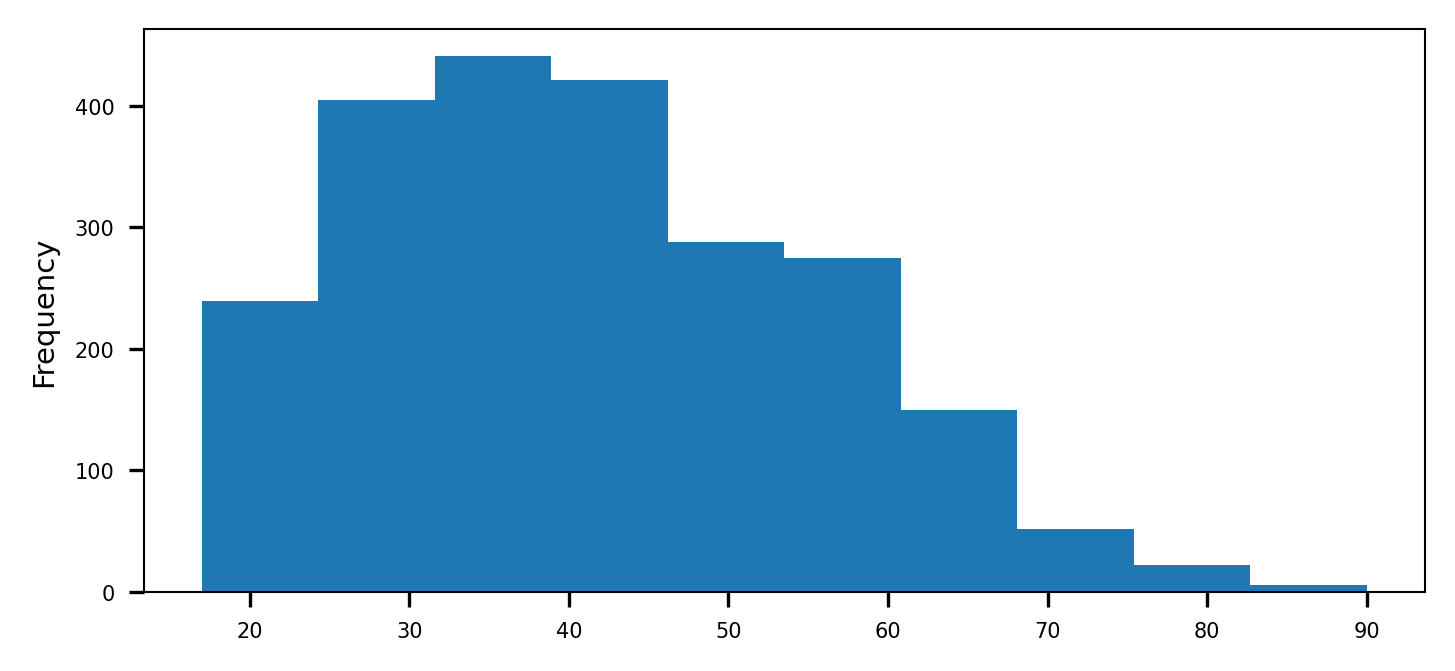

In [24]:
age = voters.loc[voters.representative].loc[voters.age!=' '].age.astype(int)
age.loc[(age<100) & (age>16)].plot.hist()

In [25]:
voters.loc[voters.representative, 'gender'].value_counts()

gender
m       1771
f        532
         112
x         13
none       8
Name: count, dtype: int64